In [1]:
import ROOT
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

ROOT.gROOT.ProcessLine( "gErrorIgnoreLevel = kError;");
ROOT.gStyle.SetCanvasDefW(2400);
ROOT.gStyle.SetCanvasDefH(900);
ROOT.gStyle.SetLegendTextSize(0.05)
ROOT.gStyle.SetLabelSize(0.05)
ROOT.gStyle.SetMarkerSize(1)
ROOT.gStyle.SetMarkerStyle(8)
ROOT.gStyle.SetLineWidth(2)
ROOT.gStyle.SetTickLength(0.02, "y")

Welcome to JupyROOT 6.31/01


In [2]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s))

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def filter_name(n):
    name_map = {
        "Stats" : "GetStats",
        "Sum" : "GetStats",
        "Histo" : "HistogramKernel",
        "ExcludeUOverflowKernel" : "GetStats",
        "InitializeToZeroTask" : "GetStats"
    }
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*", "hipsycl_kernel",
              "::operator", "ROOT::", "Experimental::", "_", "::", "]", "[", "  "]:
        n = n.replace(w, "")
    for k,v in name_map.items():
        if k in n:
            n = v

    return n.strip()

In [3]:
df = pd.read_csv("das6-gpu/20231206-174647")
df["nvals"] =  df["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
df["distribution"] =  df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df, "edges", np.bool_)
convert_to_type(df, "ttotal", np.float64)
df["type"] = "Buffers"

df_usm = pd.read_csv("das6-gpu/20231211-155923")
df_usm["nvals"] =  df_usm["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
df_usm["distribution"] =  df_usm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_usm, "edges", np.bool_)
convert_to_type(df_usm, "ttotal", np.float64)
df_usm["type"] = "USM"

df = pd.concat([df, df_usm])
del df["input"]
df

,iter,env,gpu,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution,type
0,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,3.158348,5.000000e+07,uniform,Buffers
1,0,DPC++,A4000,1,32768,True,0.0,0.0,0.0,3.143772,5.000000e+07,uniform,Buffers
2,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,3.593378,1.000000e+08,uniform,Buffers
3,0,DPC++,A4000,1,32768,True,0.0,0.0,0.0,4.094069,1.000000e+08,uniform,Buffers
4,0,DPC++,A4000,1,32768,False,0.0,0.0,0.0,9.966019,5.000000e+08,uniform,Buffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,4,DPC++,A4000,1000,32768,True,0.0,0.0,0.0,3.748883,1.000000e+08,uniform,USM
316,4,DPC++,A4000,1000,32768,False,0.0,0.0,0.0,10.399123,5.000000e+08,uniform,USM
317,4,DPC++,A4000,1000,32768,True,0.0,0.0,0.0,10.190794,5.000000e+08,uniform,USM
318,4,DPC++,A4000,1000,32768,False,0.0,0.0,0.0,18.280992,1.000000e+09,uniform,USM


In [4]:
gp = df.groupby(["env", "gpu", "type", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp.mean()

iter  \
env         gpu   type    distribution nvals        nbins bulksize edges         
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False   2.0   
                                                                   True    2.0   
                                                    10    32768    False   2.0   
                                                                   True    2.0   
                                                    100   32768    False   2.0   
...                                                                        ...   
DPC++       A4000 USM     uniform      1.000000e+09 10    32768    True    2.0   
                                                    100   32768    False   2.0   
                                                                   True    2.0   
                                                    1000  32768    False   2.0   
                                                                   True    2.0   

                                                                          tfindbin  \
env         gpu   type    distribution nvals        nbins bulksize edges             
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False       0.0   
                                                                   True        0.0   
                                                    10    32768    False       0.0   
                                                                   True        0.0   
                                                    100   32768    False       0.0   
...                                                                            ...   
DPC++       A4000 USM     uniform      1.000000e+09 10    32768    True        0.0   
                                                    100   32768    False       0.0   
                                                                   True        0.0   
                                                    1000  32768    False       0.0   
                                                                   True        0.0   

                                                                          tfill  \
env         gpu   type    distribution nvals        nbins bulksize edges          
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False    0.0   
                                                                   True     0.0   
                                                    10    32768    False    0.0   
                                                                   True     0.0   
                                                    100   32768    False    0.0   
...                                                                         ...   
DPC++       A4000 USM     uniform      1.000000e+09 10    32768    True     0.0   
                                                    100   32768    False    0.0   
                                                                   True     0.0   
                                                    1000  32768    False    0.0   
                                                                   True     0.0   

                                                                          tstats  \
env         gpu   type    distribution nvals        nbins bulksize edges           
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False     0.0   
                                                                   True      0.0   
                                                    10    32768    False     0.0   
                                                                   True      0.0   
                                                    100   32768    False     0.0   
...                                                                          ...   
DPC++       A4000 USM     uniform      1.000000e+09 10    32768    True      0.0   
                                                    

In [5]:
unique_env = df["env"].unique()
unique_bulksize = df["bulksize"].unique()
unique_nbins = df["nbins"].unique()
unique_nvals = df["nvals"].unique()
unique_gpus = df["gpu"].unique()
unique_distributions = df["distribution"].unique()
unique_edges = [True, False]
unique_type = ["Buffers", "USM"]
unique_env, unique_gpus, unique_type, unique_nbins, unique_bulksize, unique_edges, unique_nvals, unique_distributions

(array(['DPC++', 'AdaptiveCpp', 'CUDA_HIST'], dtype=object),
 array(['A4000'], dtype=object),
 ['Buffers', 'USM'],
 array([   1,   10,  100, 1000]),
 array([32768]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['uniform'], dtype=object))

In [6]:
api_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/api")
api_buf["Time"] = api_buf["Total Time (ns)"].div(1e9)
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(api_buf, "edges", np.bool_)
api_buf["type"] = "Buffers"

api_usm = pd.read_csv("das6-gpu/nsys-20231206-174647/api")
api_usm["Time"] = api_usm["Total Time (ns)"].div(1e9)
api_usm["nvals"] =  api_usm["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_usm["distribution"] =  api_usm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(api_usm, "edges", np.bool_)
api_usm["type"] = "USM"

api = pd.concat([api_buf, api_usm])
api["Name"] = api["Name"].apply(filter_name)
del api["input"]
api

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Num Calls,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,Time,nvals,distribution,type
0,0,AdaptiveCpp,A4000,1,32768,False,31.1,226624986,10690,21199.7,7865.0,6753,132465001,1281105.6,cudaLaunchKernel,0.226625,5.000000e+07,uniform,Buffers
1,0,AdaptiveCpp,A4000,1,32768,False,23.2,168862502,4,42215625.5,4097.5,2985,168851322,84423797.7,cudaStreamCreateWithFlags,0.168863,5.000000e+07,uniform,Buffers
2,0,AdaptiveCpp,A4000,1,32768,False,22.6,164683254,3064,53747.8,55674.0,5851,119444,5370.4,cudaMemcpyAsync,0.164683,5.000000e+07,uniform,Buffers
3,0,AdaptiveCpp,A4000,1,32768,False,6.6,47877497,6118,7825.7,5570.0,4238,332824,7542.2,cudaFree,0.047877,5.000000e+07,uniform,Buffers
4,0,AdaptiveCpp,A4000,1,32768,False,6.6,47789458,6118,7811.3,5600.0,4638,537979,8192.6,cudaMalloc,0.047789,5.000000e+07,uniform,Buffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,4,AdaptiveCpp,A4000,1000,32768,True,0.0,133470,1,133470.0,133470.0,133470,133470,0.0,cudaGetDevicePropertiesv2v12000,0.000133,1.000000e+09,uniform,USM
5335,4,AdaptiveCpp,A4000,1000,32768,True,0.0,102061,3,34020.3,9047.0,4508,88506,47240.5,cudaMemsetAsync,0.000102,1.000000e+09,uniform,USM
5336,4,AdaptiveCpp,A4000,1000,32768,True,0.0,29065,4,7266.3,4894.5,4579,14697,4956.1,cudaStreamDestroy,0.000029,1.000000e+09,uniform,USM
5337,4,AdaptiveCpp,A4000,1000,32768,True,0.0,22210,18,1233.9,1262.0,852,2254,350.9,cudaEventDestroy,0.000022,1.000000e+09,uniform,USM


In [7]:
gp_api = api.groupby(["env", "gpu", "type", "distribution", "nvals", "nbins", "bulksize", "edges", "Name"])
gp_api.mean()

iter  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                               
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False cuModuleGetLoadingMode       2.0   
                                                                         cudaEventCreate              2.0   
                                                                         cudaEventDestroy             2.0   
                                                                         cudaEventRecord              2.0   
                                                                         cudaEventSynchronize         2.0   
...                                                                                                   ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    True  cuModuleUnload               2.0   
                                                                         cuStreamCreateWithPriority   2.0   
                                                                         cuStreamDestroyv2            2.0   
                                                                         cuStreamSynchronize          2.0   
                                                                         cuStreamWaitEvent            2.0   

                                                                                                     Time (%)  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                                   
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False cuModuleGetLoadingMode          0.00   
                                                                         cudaEventCreate                 0.00   
                                                                         cudaEventDestroy                0.00   
                                                                         cudaEventRecord                 6.30   
                                                                         cudaEventSynchronize            1.76   
...                                                                                                       ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    True  cuModuleUnload                  1.62   
                                                                         cuStreamCreateWithPriority      0.10   
                                                                         cuStreamDestroyv2               0.00   
                                                                         cuStreamSynchronize             0.00   
                                                                         cuStreamWaitEvent               1.74   

                                                                                                     Total Time (ns)  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                                          
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False cuModuleGetLoadingMode               1360.6   
                                                                         cudaEventCreate                    202287.6   
                                                                         cudaEventDestroy                    25281.6   
                                                                         cudaEventRecord                  46411093.6   
                                                                         cudaEventSynchronize             12986268.2   
...                                                                                                              ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    True  cuModuleUnload                  104065004.4   
                                                                         cuStreamCreateWithPriority        6639014.6   
             

In [8]:
api_names = api["Name"].unique()
api_names

array(['cudaLaunchKernel', 'cudaStreamCreateWithFlags', 'cudaMemcpyAsync',
       'cudaFree', 'cudaMalloc', 'cudaEventRecord', 'cudaStreamWaitEvent',
       'cudaEventSynchronize', 'cudaEventCreate',
       'cudaGetDevicePropertiesv2v12000', 'cudaStreamDestroy',
       'cudaMemsetAsync', 'cudaEventDestroy', 'cuModuleGetLoadingMode',
       'cuModuleLoadDataEx', 'cuModuleUnload', 'cuMemcpyHtoDAsyncv2',
       'cuLaunchKernel', 'cuMemAllocv2', 'cuMemFreev2',
       'cuEventSynchronize', 'cuStreamWaitEvent', 'cuEventQuery',
       'cuEventRecord', 'cuEventCreate', 'cuEventDestroyv2',
       'cuStreamCreateWithPriority', 'cuStreamDestroyv2',
       'cuStreamSynchronize', 'cuMemcpyDtoHAsyncv2', 'cuMemcpyAsync',
       'cuMemsetD8Async', 'cuCtxSetCurrent', 'cudaMemcpy', 'cudaMemset'],
      dtype=object)

In [9]:
kernels_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/kernel")
kernels_buf["Time"] = kernels_buf["Total Time (ns)"].div(1e9)
kernels_buf["nvals"] =  kernels_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernels_buf["distribution"] =  kernels_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)
kernels_buf["type"] = "Buffers"

kernels_usm = pd.read_csv("das6-gpu/nsys-20231206-174647/kernel")
kernels_usm["Time"] = kernels_usm["Total Time (ns)"].div(1e9)
kernels_usm["nvals"] =  kernels_usm["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernels_usm["distribution"] =  kernels_usm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_usm, "edges", np.bool_)
kernels_usm["type"] = "USM"
    
kernels = pd.concat([kernels_buf, kernels_usm])
kernels["Name"] = kernels["Name"].apply(filter_name)
del kernels["input"]
kernels

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,Time,nvals,distribution,type
0,0,AdaptiveCpp,A4000,1,32768,False,72.6,81750572,1527,53536.7,53536.0,39136,55777,738.1,HistogramKernel,0.081751,5.000000e+07,uniform,Buffers
1,0,AdaptiveCpp,A4000,1,32768,False,7.1,8036343,1527,5262.8,5248.0,5215,5472,24.7,GetStats,0.008036,5.000000e+07,uniform,Buffers
2,0,AdaptiveCpp,A4000,1,32768,False,6.8,7645544,1527,5006.9,4993.0,4960,5344,21.0,GetStats,0.007646,5.000000e+07,uniform,Buffers
3,0,AdaptiveCpp,A4000,1,32768,False,4.6,5125609,1527,3356.7,3360.0,3327,3393,11.8,GetStats,0.005126,5.000000e+07,uniform,Buffers
4,0,AdaptiveCpp,A4000,1,32768,False,4.5,5121366,1527,3353.9,3360.0,3327,3392,13.3,GetStats,0.005121,5.000000e+07,uniform,Buffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,4,AdaptiveCpp,A4000,1000,32768,True,16.0,146457859,30534,4796.6,4800.0,4767,5056,17.7,GetStats,0.146458,1.000000e+09,uniform,USM
3331,4,AdaptiveCpp,A4000,1000,32768,True,11.2,102243858,30534,3348.5,3360.0,3327,3393,15.5,GetStats,0.102244,1.000000e+09,uniform,USM
3332,4,AdaptiveCpp,A4000,1000,32768,True,11.2,102141981,30534,3345.2,3359.0,3296,3393,16.0,GetStats,0.102142,1.000000e+09,uniform,USM
3333,4,AdaptiveCpp,A4000,1000,32768,True,6.0,54795424,30534,1794.6,1792.0,1600,2176,14.2,GetStats,0.054795,1.000000e+09,uniform,USM


In [10]:
gp_kernels = kernels.groupby(["env", "gpu", "type", "distribution", "nvals", "nbins", "bulksize", "edges", "Name"])
gp_kernels.mean()

iter  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                    
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False GetStats          2.0   
                                                                         HistogramKernel   2.0   
                                                                   True  GetStats          2.0   
                                                                         HistogramKernel   2.0   
                                                    10    32768    False GetStats          2.0   
...                                                                                        ...   
DPC++       A4000 USM     uniform      1.000000e+09 100   32768    True  HistogramKernel   2.0   
                                                    1000  32768    False GetStats          2.0   
                                                                         HistogramKernel   2.0   
                                                                   True  GetStats          2.0   
                                                                         HistogramKernel   2.0   

                                                                                           Time (%)  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                         
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False GetStats          3.925714   
                                                                         HistogramKernel  72.600000   
                                                                   True  GetStats          4.114286   
                                                                         HistogramKernel  71.200000   
                                                    10    32768    False GetStats          8.397143   
...                                                                                             ...   
DPC++       A4000 USM     uniform      1.000000e+09 100   32768    True  HistogramKernel  19.900000   
                                                    1000  32768    False GetStats          8.925000   
                                                                         HistogramKernel  28.600000   
                                                                   True  GetStats          9.870000   
                                                                         HistogramKernel  21.040000   

                                                                                          Total Time (ns)  \
env         gpu   type    distribution nvals        nbins bulksize edges Name                               
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False GetStats            4.403608e+06   
                                                                         HistogramKernel     8.170359e+07   
                                                                   True  GetStats            4.391557e+06   
                                                                         HistogramKernel     7.600303e+07   
                                                    10    32768    False GetStats            4.407940e+06   
...                                                                                                   ...   
DPC++       A4000 USM     uniform      1.000000e+09 100   32768    True  HistogramKernel     2.874736e+08   
                                                    1000  32768    False GetStats            1.443643e+08   
                                                                         HistogramKernel     4.625129e+08   
                                                                   True  GetStats            1.445571e+08   
                                                                         HistogramKernel     3.083512e+08   

                                                         

In [11]:
kernel_names = kernels["Name"].unique()
kernel_names

array(['HistogramKernel', 'GetStats'], dtype=object)

In [12]:
memops_buf = pd.read_csv("das6-gpu/nsys-20231211-155923/memop")
memops_buf["Time"] = memops_buf["Total Time (ns)"].div(1e9)
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
convert_to_type(kernels_buf, "edges", np.bool_)
memops_buf["type"] = "Buffers"

memops_usm = pd.read_csv("das6-gpu/nsys-20231206-174647/memop")
memops_usm["Time"] = memops_usm["Total Time (ns)"].div(1e9)
memops_usm["nvals"] =  memops_usm["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_usm["distribution"] =  memops_usm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(memops_usm, "edges", np.bool_)
memops_usm["type"] = "USM"

df_memops = pd.concat([memops_buf, memops_usm])
df_memops["Operation"] = df_memops["Operation"].apply(filter_name)
del df_memops["input"]
df_memops

,iter,env,gpu,nbins,bulksize,edges,Time (%),Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,Time,nvals,distribution,type
0,0,AdaptiveCpp,A4000,1,32768,False,100.0,47118513,3062,15388.1,15392.0,415,16321,776.4,CUDA memcpy Host-to-Device,4.711851e-02,5.000000e+07,uniform,Buffers
1,0,AdaptiveCpp,A4000,1,32768,False,0.0,3104,2,1552.0,1552.0,1536,1568,22.6,CUDA memcpy Device-to-Host,3.104000e-06,5.000000e+07,uniform,Buffers
2,0,AdaptiveCpp,A4000,1,32768,False,0.0,864,2,432.0,432.0,416,448,22.6,CUDA memset,8.640000e-07,5.000000e+07,uniform,Buffers
3,0,AdaptiveCpp,A4000,1,32768,True,100.0,46987364,3063,15340.3,15360.0,415,16033,814.6,CUDA memcpy Host-to-Device,4.698736e-02,5.000000e+07,uniform,Buffers
4,0,AdaptiveCpp,A4000,1,32768,True,0.0,2848,2,1424.0,1424.0,1344,1504,113.1,CUDA memcpy Device-to-Host,2.848000e-06,5.000000e+07,uniform,Buffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,4,AdaptiveCpp,A4000,1000,32768,False,0.0,2656,2,1328.0,1328.0,1184,1472,203.6,CUDA memcpy Device-to-Host,2.656000e-06,1.000000e+09,uniform,USM
1298,4,AdaptiveCpp,A4000,1000,32768,False,0.0,2592,3,864.0,448.0,416,1728,748.4,CUDA memset,2.592000e-06,1.000000e+09,uniform,USM
1299,4,AdaptiveCpp,A4000,1000,32768,True,100.0,938885457,61073,15373.2,15328.0,415,16288,219.3,CUDA memcpy Host-to-Device,9.388855e-01,1.000000e+09,uniform,USM
1300,4,AdaptiveCpp,A4000,1000,32768,True,0.0,2624,2,1312.0,1312.0,1216,1408,135.8,CUDA memcpy Device-to-Host,2.624000e-06,1.000000e+09,uniform,USM


In [13]:
gp_memops = df_memops.groupby(["env", "gpu", "type", "distribution", "nvals", "nbins", "bulksize", "edges", "Operation"])
gp_memops.mean()

iter  \
env         gpu   type    distribution nvals        nbins bulksize edges Operation                          
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False CUDA memcpy Device-to-Host   2.0   
                                                                         CUDA memcpy Host-to-Device   2.0   
                                                                         CUDA memset                  2.0   
                                                                   True  CUDA memcpy Device-to-Host   2.0   
                                                                         CUDA memcpy Host-to-Device   2.0   
...                                                                                                   ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    False CUDA memcpy Host-to-Device   2.0   
                                                                         CUDA memset                  2.0   
                                                                   True  CUDA memcpy Device-to-Host   2.0   
                                                                         CUDA memcpy Host-to-Device   2.0   
                                                                         CUDA memset                  2.0   

                                                                                                     Time (%)  \
env         gpu   type    distribution nvals        nbins bulksize edges Operation                              
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False CUDA memcpy Device-to-Host       0.0   
                                                                         CUDA memcpy Host-to-Device     100.0   
                                                                         CUDA memset                      0.0   
                                                                   True  CUDA memcpy Device-to-Host       0.0   
                                                                         CUDA memcpy Host-to-Device     100.0   
...                                                                                                       ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    False CUDA memcpy Host-to-Device     100.0   
                                                                         CUDA memset                      0.0   
                                                                   True  CUDA memcpy Device-to-Host       0.0   
                                                                         CUDA memcpy Host-to-Device     100.0   
                                                                         CUDA memset                      0.0   

                                                                                                     Total Time (ns)  \
env         gpu   type    distribution nvals        nbins bulksize edges Operation                                     
AdaptiveCpp A4000 Buffers uniform      5.000000e+07 1     32768    False CUDA memcpy Device-to-Host           2950.2   
                                                                         CUDA memcpy Host-to-Device       47148652.4   
                                                                         CUDA memset                           864.0   
                                                                   True  CUDA memcpy Device-to-Host           2905.8   
                                                                         CUDA memcpy Host-to-Device       47142131.6   
...                                                                                                              ...   
DPC++       A4000 USM     uniform      1.000000e+09 1000  32768    False CUDA memcpy Host-to-Device      946041115.4   
                                                                         CUDA memset                          2138.0   
             

In [14]:
memops_names = df_memops["Operation"].unique()
memops_names

array(['CUDA memcpy Host-to-Device', 'CUDA memcpy Device-to-Host',
       'CUDA memset'], dtype=object)

## A4000

In [15]:
selected_env = unique_env
selected_bulksize = 32768
selected_type = unique_type
selected_bins = 1000
selected_nvals = unique_nvals
selected_gpu = "A4000"
selected_distr = "uniform"
selected_edges = True

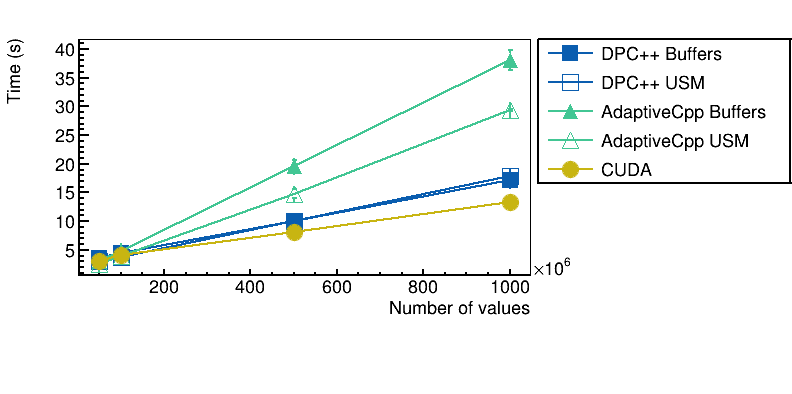

In [19]:
%jsroot off
title = f"Total Runtime of Histo1D with Different Input Sizes on NVIDIA A4000"

w = 800
h = 450
c = ROOT.TCanvas("c1", "", w, h)
c.SetRightMargin(0.33)
c.SetBottomMargin(0.3)

mg = ROOT.TMultiGraph()

l = ROOT.TLegend(0.68, 0.533, 1, 0.9)
l.SetTextSize(0.05)
markerstyles = [21, 25, 22, 26, 20]

ROOT.gStyle.SetPalette(ROOT.kRainbow)  
for ei, env in enumerate(selected_env):
    for ti, type in enumerate(selected_type):
        if type == "USM" and "CUDA" in env:
            continue 
        avg = np.array(gp.mean().loc[env, selected_gpu, type, selected_distr, :, 
                       selected_bins, selected_bulksize, selected_edges]["ttotal"], dtype=np.float64)
        std = np.array(gp.std().loc[env, selected_gpu, type, selected_distr, :,
                       selected_bins, selected_bulksize, selected_edges]["ttotal"], dtype=np.float64)
        gr = ROOT.TGraphErrors(len(selected_nvals), selected_nvals.astype(np.float64), avg, 
                               np.repeat(0., len(selected_nvals)), std)
    
        color = ROOT.TColor.GetPalette()[50+ 60 * ei]
        gr.SetMarkerColor(color)
        gr.SetLineColor(color)
        gr.SetLineWidth(2)
        gr.SetMarkerSize(2)
        gr.SetMarkerStyle(markerstyles[2*ei + ti])
        
        gr.GetHistogram().SetMinimum(0)
        gr.GetHistogram().SetLineWidth(10)
    
        mg.Add(gr, "ALP ")
        l.AddEntry(gr, env.split("_")[0] + " " + (type if "CUDA" not in env else ""))

# mg.SetTitle(title)

xaxis = mg.GetXaxis()
# xaxis.SetTitle("#splitline{Bulk Size}")
xaxis.SetTitle("Number of values")
# xaxis.SetRangeUser(0, 10000000)
# xaxis.SetTitleOffset(1.5)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

yaxis = mg.GetYaxis()
yaxis.SetTitle("Time (s)")
yaxis.SetTitleOffset(1)
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

mg.Draw("a")
l.Draw()
c.SaveAs(f"sycl_totalruntime.pdf")
c.DrawClone()

In [24]:
%jsroot on
def get_cell(df, index_name, col):
    return df.loc[index_name][col]
    
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(3)
    if s:
        h.SetFillStyle(s)
        
nbins = len(selected_env) * len(selected_nvals) + len(selected_nvals) + 1
# nbins = len(selected_env) * len(selected_type) * len(selected_nvals) + \
#         len(selected_type) * len(selected_nvals) + 1
title = f"Nsys profiling results for time spent on GPU when filling a 1D histogram with RDataFrame"
gpuFillStyle = [None, None, None, None]
ROOT.gStyle.SetErrorX(0.);    

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetRightMargin(0.36)
c.SetBottomMargin(0.4)

hs = ROOT.THStack("hs", "")

l = ROOT.TLegend(0.65, 0.5, 1, 0.9)
# l = ROOT.TLegend()
l.SetTextSize(0.05)

unique_kernels = []

for ei, env in enumerate(selected_env):
    ROOT.gStyle.SetPalette(ROOT.kBlackBody)
    for mi, memop in enumerate(memops_names):
        bin = 1 + ei
        for nvi, nv in enumerate(selected_nvals):
            memop_avg = gp_memops.mean().loc[env, selected_gpu, 
                         type, selected_distr, nv, selected_bins, 
                         selected_bulksize, selected_edges]
            memop_std = gp_memops.std().loc[env, selected_gpu, 
                         type, selected_distr, nv, selected_bins, 
                         selected_bulksize, selected_edges]

            if len(memop_avg) == 0 or memop not in memop_avg.index:
                continue
    
            h3 = ROOT.TH1F(f"{nv}_{memop}", "gpu", nbins, 0, nbins)
            fill_bar(
                h3,
                bin,
                get_cell(memop_avg, memop, "Time"),
                get_cell(memop_std, memop, "Time"),
                ROOT.TColor.GetPalette()[50 * mi],
                gpuFillStyle[ei],
            )
            h3.SetLineWidth(3)
            hs.Add(h3)
            bin += len(selected_env) + 1
        if ei == 0:
            l.AddEntry(h3, memop)
            
    ROOT.gStyle.SetPalette(ROOT.kRainbow)
    for ni, name in enumerate(kernel_names):
        bin = 1 + ei 
        for nvi, nv in enumerate(selected_nvals):
            kernel_avg = gp_kernels.mean().loc[env, selected_gpu, 
                         type, selected_distr, nv, selected_bins, 
                         selected_bulksize, selected_edges]
            kernel_std = gp_kernels.std().loc[env, selected_gpu, 
                         type, selected_distr, nv, selected_bins, 
                         selected_bulksize, selected_edges]

            if len(kernel_avg) == 0 or name not in kernel_avg.index:
                continue
                
            h1 = ROOT.TH1F(f"{nv}_{name}", "gpu", nbins, 0, nbins)
            fill_bar(
                h1,
                bin,
                get_cell(kernel_avg, name, "Time"),
                get_cell(kernel_std, name, "Time"),
                ROOT.TColor.GetPalette()[60 * ni],
                gpuFillStyle[ei],
            )
            h1.SetLineWidth(3)
            hs.Add(h1)
            bin += len(selected_env) + 1
        if name not in unique_kernels:
            l.AddEntry(h1, name)
            unique_kernels.append(name)

    # ROOT.gStyle.SetPalette(ROOT.kCool)
    # for ni, name in enumerate(api_names):
    #     bin = 1 + ei 
    #     for nvi, nv in enumerate(selected_nvals):
    #         api_avg = gp_api.mean().loc[env, selected_gpu, 
    #                      type, selected_distr, nv, selected_bins, 
    #                      selected_bulksize, selected_edges]
    #         api_std = gp_api.std().loc[env, selected_gpu, 
    #                      type, selected_distr, nv, selected_bins, 
    #                      selected_bulksize, selected_edges]

    #         if len(api_avg) == 0 or name not in api_avg.index:
    #             continue
                
    #         h3 = ROOT.TH1F(f"api_{nv}_{name}", "gpu", nbins, 0, nbins)
    #         fill_bar(
    #             h1,
    #             bin,
    #             get_cell(api_avg, name, "Time"),
    #             get_cell(api_std, name, "Time"),
    #             ROOT.TColor.GetPalette()[6 * ni],
    #             gpuFillStyle[ei],
    #         )
    #         h3.SetLineWidth(3)
    #         hs.Add(h3)
    #         bin += len(selected_env) + 1
    #     if name not in unique_kernels:
    #         l.AddEntry(h3, name)
    #         unique_kernels.append(name)

hs.Draw("bar")
hs.SetTitle(title)
# hs.SetMaximum(120)

xaxis = hs.GetXaxis()
xaxis.SetTitle("#splitline{      Implementation}{Number of doubles}")
# xaxis.SetTitle("Bulk size")
xaxis.SetTitleOffset(4)
xaxis.SetLabelSize(0.05)
for i, e in enumerate(range(2, nbins, len(selected_env) + 1)):
    # for ei, env in enumerate(environs):
    for ei, env in enumerate(selected_env):
        xaxis.SetBinLabel(e + ei, f"{env.split('_')[0]}")
        # xaxis.SetBinLabel(e + ei, f"")
xaxis.LabelsOption("vM")
xaxis.SetTickSize(0)
xaxis.SetTitleSize(0.05)
xaxis.SetLabelSize(0.05)

ox = ROOT.TGaxis(
    0,
    0,  # xmin, ymin
    nbins,
    0,  # xmax, ymax
    0,
    nbins,  # wmin, wmax
    nbins,
        "S",  # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.2)
ox.SetLabelFont(42)
ox.SetLabelSize(0.05)

labelbins = range(2, nbins + 1, len(selected_env) + 1)
vallabels = ["50M", "100M", "500M", "  1B"]
for i in range(nbins + 2):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 0, -1, 12, -1, -1, vallabels[i])

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Time (s)")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)

ROOT.gStyle.SetTitleFontSize(0.1)

l.Draw()
c.DrawClone()
# c.SaveAs(f"nsys_histogram_{env}.png")

## A6000

## A2